# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [1]:
!pip -q install ./python
from unityagents import UnityEnvironment
import numpy as np
import workspace_utils
from workspace_utils import active_session

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# # reset the environment
# env_info = env.reset(train_mode=True)[brain_name]

# # number of agents
# num_agents = len(env_info.agents)
# print('Number of agents:', num_agents)

# # size of each action
# action_size = brain.vector_action_space_size
# print('Size of each action:', action_size)

# # examine the state space 
# states = env_info.vector_observations
# state_size = states.shape[1]
# print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


When finished, you can close the environment.

In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [2]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
from ddpg_agent import Agent
from unityagents import UnityEnvironment
import torch
import torch.nn.functional as F
import torch.optim as optim


#select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


In [4]:
from tqdm import tqdm_notebook

In [5]:
# number of agents
num_agents = len(env_info.agents)
num_steps = 1000
num_episodes = 500

scores_window = deque(maxlen=100)
scores = np.zeros(num_agents)
scores_episode = []
agents = []

for i in range(num_agents):
    agents.append(Agent(state_size, action_size, random_seed=0))

with active_session():
    for episode in tqdm_notebook(range(1, num_episodes+1)):
        print(f"starting episode {episode} ")
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations

        for agent in agents:
            agent.reset()

        scores = np.zeros(num_agents)

        for step in range(num_steps):
            actions = np.array([agents[i].act(states[i]) for i in range(num_agents)])

            env_info = env.step(actions)[brain_name]

            next_states = env_info.vector_observations
            rewards = env_info.rewards
            # print(rewards)
            dones = env_info.local_done

            for i in range(num_agents):
                agents[i].step(step, states[i], actions[i], rewards[i], next_states[i], dones[i]) 

            states = next_states
            scores += rewards

            if np.any(dones):
                break
        score = np.mean(scores)
        scores_window.append(score)       # save most recent score
        scores_episode.append(score)
        window_scores = np.mean(scores_window) 
        
        print(f"Episode:{episode}, Score:{window_scores}")
        
        if window_scores >=30.0:
            print(f"solved in {episode} episodes with average score of {window_scores}")
            torch.save(Agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(Agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break


# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_episode)), scores_episode)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Initialising ReplayBuffer


HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

starting episode 1 
Episode:1, Score:0.5004999888129532
starting episode 2 
Episode:2, Score:0.7439249833719804
starting episode 3 
Episode:3, Score:0.8777166470481703
starting episode 4 
Episode:4, Score:1.2928499711025505
starting episode 5 
Episode:5, Score:1.734979961220175
starting episode 6 
Episode:6, Score:2.0131582883357386
starting episode 7 
Episode:7, Score:2.368971375620791
starting episode 8 
Episode:8, Score:2.8522811862465463
starting episode 9 
Episode:9, Score:3.265888815890584
starting episode 10 
Episode:10, Score:3.613089919241146
starting episode 11 
Episode:11, Score:4.059309000176462
starting episode 12 
Episode:12, Score:4.46625823350468
starting episode 13 
Episode:13, Score:4.844649891713634
starting episode 14 
Episode:14, Score:5.302421310053073
starting episode 15 
Episode:15, Score:5.626529874237255
starting episode 16 
Episode:16, Score:5.878843618597602
starting episode 17 
Episode:17, Score:6.276476330298054
starting episode 18 
Episode:18, Score:6.635

NameError: name 'plt' is not defined

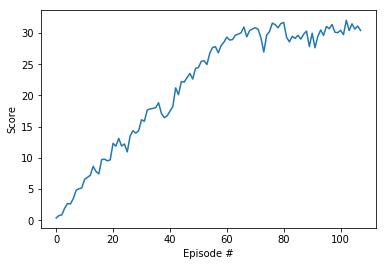

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_episode)), scores_episode)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [2]:
# using saved model
import numpy as np
import random
import copy
from collections import namedtuple, deque
from ddpg_agent import Agent
from unityagents import UnityEnvironment
import torch
import torch.nn.functional as F
import torch.optim as optim


#select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
from ddpg_model import Actor, Critic
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


In [4]:
scores = np.zeros(num_agents)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

random_seed=0
Agent.actor_local = Actor(state_size, action_size, random_seed).to(device)
Agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))

agents =[] 

for i in range(num_agents):
    agents.append(Agent(state_size, action_size, random_seed=0))
    
while True:
    actions = np.array([agents[i].act(states[i]) for i in range(num_agents)])

    env_info = env.step(actions)[brain_name]        # send the action to the environment
    next_states = env_info.vector_observations     # get the next state
    rewards = env_info.rewards                     # get the reward
    dones = env_info.local_done        

    states = next_states
    scores += rewards

    print(f'Score: {np.mean(scores)}')
    
    if np.any(dones):
        break
        


Initialising ReplayBuffer
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.003999999910593033
Score: 0.009999999776482582
Score: 0.018499999586492778
Score: 0.030499999318271874
Score: 0.04649999896064401
Score: 0.06949999844655394
Score: 0.09499999787658453
Score: 0.1254999971948564
Score: 0.15899999644607304
Score: 0.19299999568611384
Score: 0.2269999949261546
Score: 0.2619999941438437
Score: 0.2979999933391809
Score: 0.33599999248981477
Score: 0.37399999164044856
Score: 0.4119999907910824
Score: 0.4499999899417162
Score: 0.48799998909235
Score: 0.5259999882429838
Score: 0.5639999873936177
Score: 0.6019999865442515
Score: 0.6399999856948853
Score: 0.6799999848008156
Score: 0.7184999839402735
Score: 0.7564999830909074
Score: 0.7944999822415412
Score: 0.8314999814145267
Score: 0.867499980609864
Score: 0.9049999797716737
Score: 0.9429999789223075
Score: 0.9809999780729413
Score: 1.0189999772235752
Score: 1.0569999763742088
Score